#### <center>Intermediate Python and Software Enginnering</center>


## <center>Section 08 - Part 07 - Numba </center>


### <center>Innovation Scholars Programme</center>
### <center>King's College London, Medical Research Council and UKRI <center>

## CPython Interface

* The base interpreter, CPython, has its own interface in C
* Allows the definition of routines, types, etc. in compiled code
* Many built-in types and routines are implemented this way
* A C module using this interface can be compiled into a shared library and loaded like a Python module
* Rather painful 🙁

* C code needs to be written to use the CPython API and compiled to a shared object, hard for this to be portable
* Alternative is to write regular C/C++ and use a wrapper generator, eg. SWIG
* Generates code to compile to a shared object to be loaded as a Python module, this calls the C/C++ code
* Can also load and call shared objects through the `ctypes` module, also painful 🙁

## Numba

* Library for compiling Python code into native code at runtime
* Reads Python code and re-interprets it as C code then sends this off to a compiler
* Understands Numpy types and is able to generate fast code directly accessing their memory
* Typically used as a decorator `jit` on functions

In [7]:
from numba import jit
import numpy as np

# nopython=True raises an error if compilation fails, silent otherwise
@jit(nopython=True)
def example(result, a, b):
    for i in range(len(result)):
        result[i] = np.exp(a[i] * 0.2 + b[i] * 0.8)


a = np.random.rand(10 ** 5)
b = np.random.rand(a.shape[0])
result = np.zeros_like(a)

%timeit np.exp(a * 0.2 + b * 0.8) # equivalent Numpy
%timeit example(result,a,b)
%timeit example.py_func(result,a,b) # original Python code

1.67 ms ± 88 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.39 ms ± 11 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
160 ms ± 2.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


* Function `example` is defined in a constrained subset of Python
* Must use object types and idioms Numba can understand how to convert to C
* This includes Python primitives, using `range` in for loops, Numpy arrays
* Code is not compiled until first invocation of function, by default argument/return types are inferred at this point to determine how to compile
* Types can be explicitly stated in decorator

* Argument type is important property, essentially some static typing rules are being applied
* Can fail if arguments are not compatible with those it was compiled for:

In [6]:
try:
    lr = range(10 ** 5)
    example(lr, a, b)
except Exception as e:
    print(e)

Failed in nopython mode pipeline (step: nopython frontend)
non-precise type pyobject
[1] During: typing of argument at <ipython-input-1-bb15d7b8645f> (7)

File "<ipython-input-1-bb15d7b8645f>", line 7:
def example(result, a, b):
    for i in range(len(result)):
    ^

This error may have been caused by the following argument(s):
- argument 0: cannot determine Numba type of <class 'range'>

This error may have been caused by the following argument(s):
- argument 0: cannot determine Numba type of <class 'range'>



* `jit` has a `nogil` option to disable the GIL during execution
* Intepreter-safe since code shouldn't use Python objects
* As normal:

In [26]:
from multiprocessing.pool import ThreadPool

num_threads = 12
with ThreadPool(num_threads) as p:
    asplit = np.array_split(a, num_threads)
    bsplit = np.array_split(b, num_threads)
    rsplit = np.array_split(result, num_threads)
    %timeit p.starmap(example, zip(rsplit, asplit, bsplit))

2.42 ms ± 203 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<IPython.core.display.Javascript object>

* With `nogil`:

In [27]:
@jit(nopython=True, nogil=True)
def example(result, a, b):
    for i in range(len(result)):
        result[i] = np.exp(a[i] * 0.2 + b[i] * 0.8)


with ThreadPool(num_threads) as p:
    asplit = np.array_split(a, num_threads)
    bsplit = np.array_split(b, num_threads)
    rsplit = np.array_split(result, num_threads)
    %timeit p.starmap(example, zip(rsplit,asplit,bsplit))

354 µs ± 14.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<IPython.core.display.Javascript object>

* Still not as fast as the Numpy equivalent but getting speed-up from threads finally
* Algorithms which cannot be vectorized would benefit much more from Numba compilation
* Numba has other facilities for compiling classes or even whole modules, using CUDA for GPU computation, array stencils, etc.

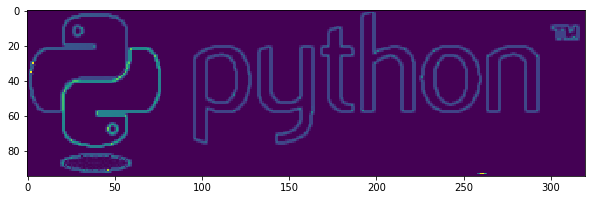

In [9]:
%matplotlib inline
from numba import stencil
import matplotlib.pyplot as plt

im = plt.imread("Python_logo_and_wordmark.svg.png")


@stencil(neighborhood=((-1, 1), (-1, 1)), cval=0.0)
def kernel1(a):  # laplace operator for edge-detection
    total = a[1, 1] * 9.0
    for x in range(0, 3):
        for y in range(0, 3):
            total -= a[x, y]

    return abs(total)


f = plt.figure(figsize=(10, 10))
plt.imshow(kernel1(im[..., 1]))